# 🌊 Full Waveform Inversion — Seismic Velocity Prediction

This notebook explores the  Waveform Inversion (FWI), where the goal is to predict subsurface **velocity maps** from **seismic waveform recordings**.

### What is Full Waveform Inversion?
Imagine hitting the ground with a hammer and listening to how the sound waves travel through the earth. 
Different rock layers have different densities, which means seismic waves travel through them at different speeds.

By recording these waves at the surface, we can work **backwards** to figure out what's underground — 
this is exactly what oil companies, geologists, and earthquake scientists do in real life.

### Our Approach
We treat this as an **image-to-image deep learning problem**:
- **Input:** 5 seismic shot recordings (time × receiver grids)
- **Output:** A 2D velocity map (depth × width) showing how fast waves travel underground

We use a **UNet** architecture — the same type of model used in medical image segmentation — to learn this mapping.

## Step 1 — Imports
Loading the standard libraries we need for data exploration: NumPy for array operations and Matplotlib for visualization.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

## Step 2 — Exploring the Data Structure

The dataset contains multiple geological scenario types, each with different subsurface patterns:
- **CurveVel / FlatVel** — smoothly varying velocity fields
- **CurveFault / FlatFault** — velocity fields with sharp fault boundaries
- **Style A/B** — different complexity levels

Let's first understand how the data is organized on disk.

In [ ]:
data_path = "../data/train_samples"

files = os.listdir(data_path)
print(f"Total files: {len(files)}")
print("Sample files:", files[:10])

Total files: 10
Sample files: ['CurveVel_A', 'CurveFault_A', 'Style_A', 'FlatVel_B', 'FlatFault_B', 'CurveVel_B', 'Style_B', 'CurveFault_B', 'FlatVel_A', 'FlatFault_A']


In [ ]:
data_path = "../data/train_samples"

for root, dirs, files in os.walk(data_path):
    level = root.replace(data_path, '').count(os.sep)
    indent = '  ' * level
    print(f"{indent}{os.path.basename(root)}/")
    if level < 2:  # only show files 2 levels deep
        for f in files[:5]:
            print(f"  {indent}{f}")
        if len(files) > 5:
            print(f"  {indent}... and {len(files)-5} more files")

train_samples/
  CurveVel_A/
    model/
    data/
  CurveFault_A/
    vel2_1_0.npy
    seis4_1_0.npy
    seis2_1_0.npy
    vel4_1_0.npy
  Style_A/
    model/
    data/
  FlatVel_B/
    model/
    data/
  FlatFault_B/
    vel8_1_0.npy
    seis6_1_0.npy
    vel6_1_0.npy
    seis8_1_0.npy
  CurveVel_B/
    model/
    data/
  Style_B/
    model/
    data/
  CurveFault_B/
    vel8_1_0.npy
    seis6_1_0.npy
    vel6_1_0.npy
    seis8_1_0.npy
  FlatVel_A/
    model/
    data/
  FlatFault_A/
    vel2_1_0.npy
    seis4_1_0.npy
    seis2_1_0.npy
    vel4_1_0.npy


In [ ]:
# Walk into subfolders to find actual files
all_files = []
for root, dirs, files in os.walk(data_path):
    for f in files:
        all_files.append(os.path.join(root, f))

print(f"Total files found: {len(all_files)}")
print("Sample paths:")
for f in all_files[:5]:
    print(" ", f)

Total files found: 40
Sample paths:
  ../data/train_samples/CurveVel_A/model/model1.npy
  ../data/train_samples/CurveVel_A/model/model2.npy
  ../data/train_samples/CurveVel_A/data/data1.npy
  ../data/train_samples/CurveVel_A/data/data2.npy
  ../data/train_samples/CurveFault_A/vel2_1_0.npy


In [ ]:
# Load a seismic (input) file
seis = np.load("../data/train_samples/CurveFault_A/seis2_1_0.npy", allow_pickle=True)

# Load matching velocity (target) file
vel = np.load("../data/train_samples/CurveFault_A/vel2_1_0.npy", allow_pickle=True)

print("=== Seismic Waveform ===")
print(f"Shape: {seis.shape}")
print(f"Dtype: {seis.dtype}")
print(f"Min: {seis.min():.4f}, Max: {seis.max():.4f}")

print("\n=== Velocity Map ===")
print(f"Shape: {vel.shape}")
print(f"Dtype: {vel.dtype}")
print(f"Min: {vel.min():.4f}, Max: {vel.max():.4f}")

=== Seismic Waveform ===
Shape: (500, 5, 1000, 70)
Dtype: float32
Min: -26.0585, Max: 52.2163

=== Velocity Map ===
Shape: (500, 1, 70, 70)
Dtype: float32
Min: 1501.0000, Max: 4500.0000


## Step 3 - Visualizing Seismic Waveforms and Velocity Maps

Each sample has **5 seismic sources** — think of it as setting off 5 small explosions at different 
locations on the surface and recording what comes back.

The **velocity map** on the right is what we're trying to predict — it shows the underground 
structure, where brighter colors = faster wave speeds = denser/harder rock layers.

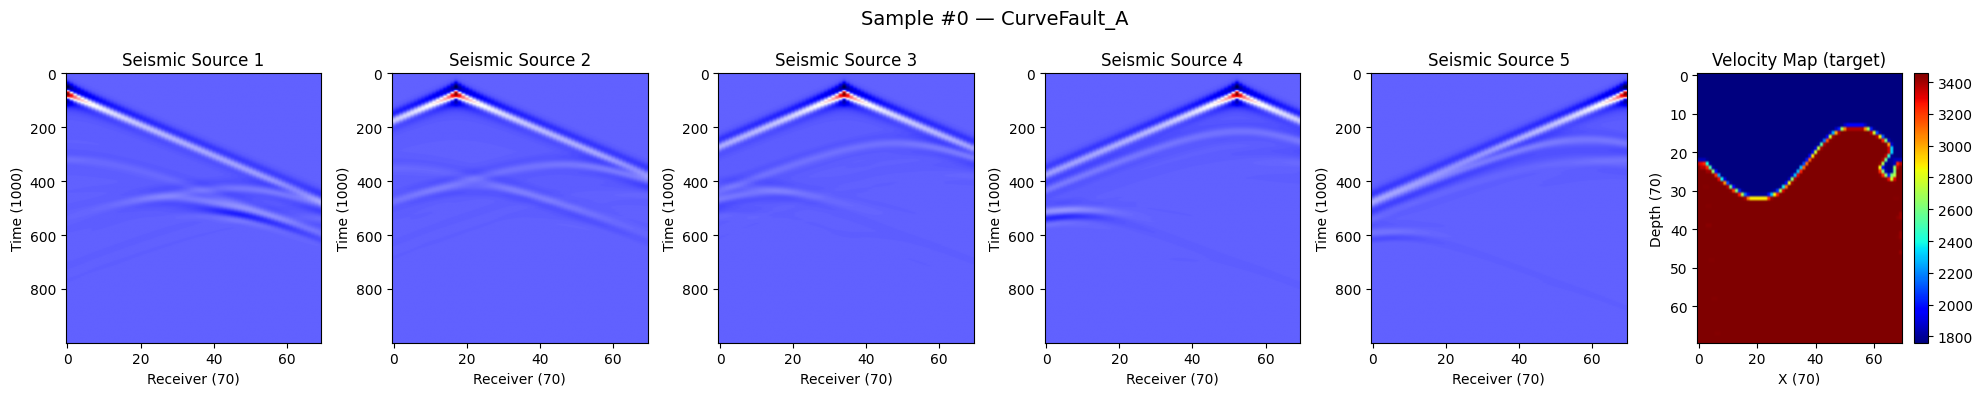

In [34]:
sample_idx = 0  # pick first sample out of 500
source_idx = 0  # pick first source out of 5

fig, axes = plt.subplots(1, 6, figsize=(20, 4))

# Show all 5 seismic sources for this sample
for i in range(5):
    axes[i].imshow(seis[sample_idx, i], cmap='seismic', aspect='auto')
    axes[i].set_title(f"Seismic Source {i+1}")
    axes[i].set_xlabel("Receiver (70)")
    axes[i].set_ylabel("Time (1000)")

# Show the velocity map
im = axes[5].imshow(vel[sample_idx, 0], cmap='jet', aspect='auto')
axes[5].set_title("Velocity Map (target)")
axes[5].set_xlabel("X (70)")
axes[5].set_ylabel("Depth (70)")
plt.colorbar(im, ax=axes[5])

plt.suptitle(f"Sample #{sample_idx} — CurveFault_A", fontsize=14)
plt.tight_layout()
plt.show()

## Step 5 - Data Statistics

Let's look at the distribution of velocity values across the dataset. 
This tells us about the range and spread of what we're trying to predict, 
which will inform how we normalize the data for training.

Total samples in this file: 500
Input shape per sample:  (5 sources, 1000 timesteps, 70 receivers) = (5, 1000, 70)
Target shape per sample: (1 channel, 70 depth, 70 width) = (1, 70, 70)

Velocity range: 1501 m/s  to  4500 m/s
Seismic range:  -26.0585  to  52.2163


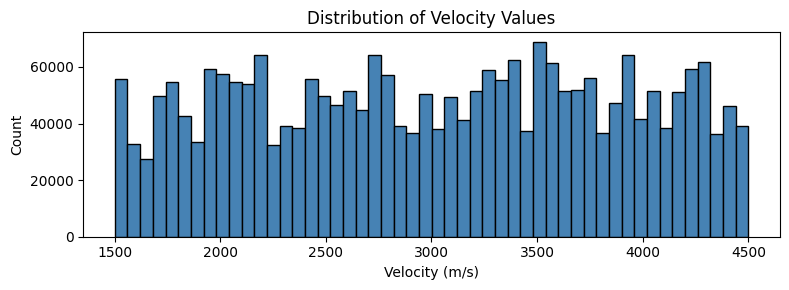

In [ ]:
print(f"Total samples in this file: {seis.shape[0]}")
print(f"Input shape per sample:  (5 sources, 1000 timesteps, 70 receivers) = {seis[0].shape}")
print(f"Target shape per sample: (1 channel, 70 depth, 70 width) = {vel[0].shape}")
print(f"\nVelocity range: {vel.min():.0f} m/s  to  {vel.max():.0f} m/s")
print(f"Seismic range:  {seis.min():.4f}  to  {seis.max():.4f}")

# Show velocity distribution
plt.figure(figsize=(8, 3))
plt.hist(vel.flatten(), bins=50, color='steelblue', edgecolor='k')
plt.title("Distribution of Velocity Values")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [31]:
import sys
sys.path.append("../src")

from dataset import SeismicDataset, get_dataloaders

# Test dataset
data_root = "../data/train_samples"
train_loader, val_loader = get_dataloaders(data_root, batch_size=4)

# Check one batch
seis_batch, vel_batch = next(iter(train_loader))
print(f"Seismic batch shape: {seis_batch.shape}")   # (4, 5, 1000, 70)
print(f"Velocity batch shape: {vel_batch.shape}")   # (4, 1, 70, 70)
print(f"Seismic range after norm: {seis_batch.min():.3f} to {seis_batch.max():.3f}")
print(f"Velocity range after norm: {vel_batch.min():.3f} to {vel_batch.max():.3f}")

✅ Dataset ready: 10000 total samples
Train samples: 9000 | Val samples: 1000
Train batches: 2250 | Val batches: 250
Seismic batch shape: torch.Size([4, 5, 1000, 70])
Velocity batch shape: torch.Size([4, 1, 70, 70])
Seismic range after norm: -16.949 to 34.267
Velocity range after norm: 0.029 to 0.903


In [32]:
import sys
import importlib

# Force remove cached version
if 'model' in sys.modules:
    del sys.modules['model']

sys.path.append("../src")

import torch
import model as model_module
importlib.reload(model_module)

from model import WaveformUNet, count_parameters

# Build model
model = WaveformUNet(base_ch=64)
count_parameters(model)

# Test forward pass
dummy_input = torch.randn(4, 5, 1000, 70)
output = model(dummy_input)

print(f"\nInput shape:  {dummy_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Output range: {output.min():.3f} to {output.max():.3f}")

Total parameters:     12,510,881
Trainable parameters: 12,510,881

Input shape:  torch.Size([4, 5, 1000, 70])
Output shape: torch.Size([4, 1, 70, 70])
Output range: 0.183 to 0.841


In [33]:
import sys
import importlib

for mod in ['train', 'model', 'dataset']:
    if mod in sys.modules:
        del sys.modules[mod]

sys.path.append("../src")
import train as train_module
importlib.reload(train_module)
from train import train

model, history = train(
    data_root      = "../data/train_samples",
    checkpoint_dir = "../outputs/checkpoints",
    epochs         = 2,
    batch_size     = 8,
    lr             = 1e-3,
)

Using device: mps
✅ Dataset ready: 10000 total samples
Train samples: 9000 | Val samples: 1000
Train batches: 1125 | Val batches: 125
Total parameters:     12,510,881
Trainable parameters: 12,510,881

🚀 Starting training for 2 epochs...

── Epoch 1/2 ──────────────────────────


KeyboardInterrupt: 

In [ ]:
import sys, importlib
for mod in ['model', 'dataset', 'train']:
    if mod in sys.modules:
        del sys.modules[mod]

sys.path.append("../src")

import torch
import numpy as np
import matplotlib.pyplot as plt
from model import WaveformUNet
from dataset import SeismicDataset

# Load dataset
dataset = SeismicDataset("../data/train_samples", normalize=True)

# Load best model
device = torch.device("cpu")
model  = WaveformUNet(base_ch=64).to(device)

checkpoint = torch.load("../outputs/checkpoints/best_model.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ Loaded model from epoch {checkpoint['epoch']}")
print(f"   Val Loss: {checkpoint['val_loss']:.4f}")
print(f"   Val MAE:  {checkpoint['val_mae']:.1f} m/s")

✅ Dataset ready: 10000 total samples
✅ Loaded model from epoch 2
   Val Loss: 0.1426
   Val MAE:  383.5 m/s


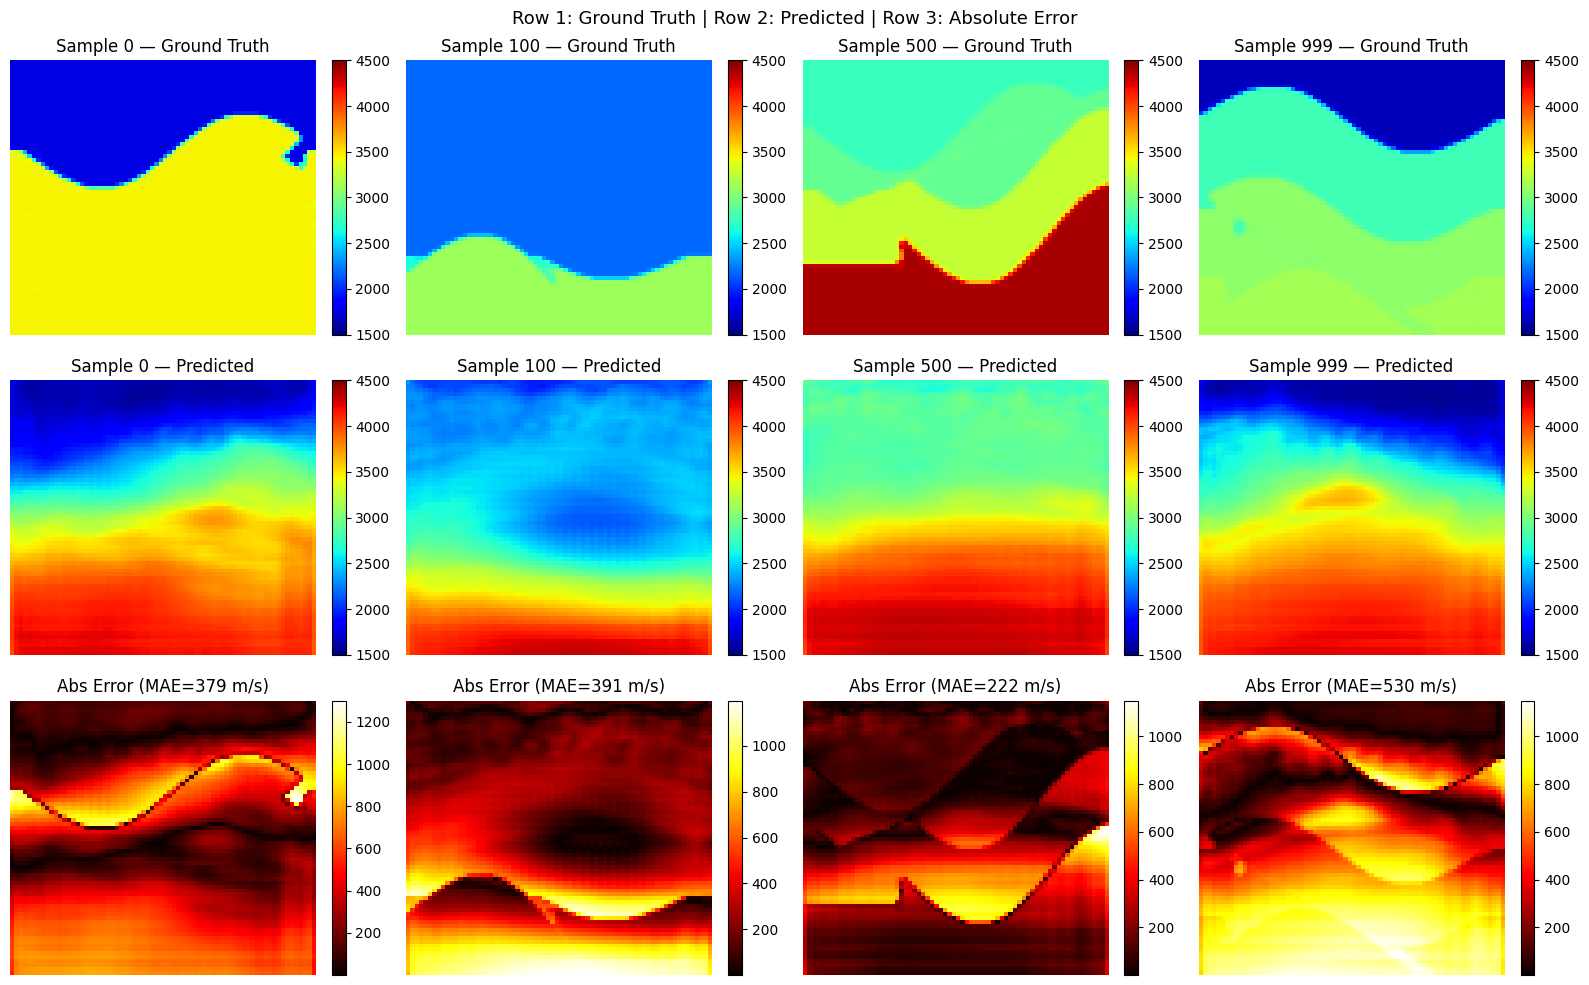

✅ Saved to outputs/predictions_visualization.png


In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(16, 10))

indices = [0, 100, 500, 999]

for col, idx in enumerate(indices):
    seis, vel_true = dataset[idx]

    with torch.no_grad():
        vel_pred = model(seis.unsqueeze(0)).squeeze().numpy()

    vel_true_np = vel_true.squeeze().numpy()

    # Denormalize to m/s
    vel_true_ms = vel_true_np * 3000.0 + 1500.0
    vel_pred_ms = vel_pred    * 3000.0 + 1500.0
    error_map   = np.abs(vel_pred_ms - vel_true_ms)

    vmin, vmax = 1500, 4500

    im0 = axes[0, col].imshow(vel_true_ms, cmap='jet', vmin=vmin, vmax=vmax, aspect='auto')
    axes[0, col].set_title(f"Sample {idx} — Ground Truth")
    axes[0, col].axis('off')
    plt.colorbar(im0, ax=axes[0, col], fraction=0.046)

    im1 = axes[1, col].imshow(vel_pred_ms, cmap='jet', vmin=vmin, vmax=vmax, aspect='auto')
    axes[1, col].set_title(f"Sample {idx} — Predicted")
    axes[1, col].axis('off')
    plt.colorbar(im1, ax=axes[1, col], fraction=0.046)

    im2 = axes[2, col].imshow(error_map, cmap='hot', aspect='auto')
    axes[2, col].set_title(f"Abs Error (MAE={error_map.mean():.0f} m/s)")
    axes[2, col].axis('off')
    plt.colorbar(im2, ax=axes[2, col], fraction=0.046)

plt.suptitle("Row 1: Ground Truth | Row 2: Predicted | Row 3: Absolute Error", fontsize=13)
plt.tight_layout()
plt.savefig("../outputs/predictions_visualization.png", dpi=150, bbox_inches='tight')
plt.show()
print("✅ Saved to outputs/predictions_visualization.png")

In [ ]:
maes = []
for idx in range(min(200, len(dataset))):
    seis, vel_true = dataset[idx]
    with torch.no_grad():
        vel_pred = model(seis.unsqueeze(0)).squeeze()
    mae = torch.mean(torch.abs(vel_pred - vel_true)).item() * 3000.0
    maes.append(mae)

print(f"Average MAE over 200 samples: {np.mean(maes):.1f} m/s")
print(f"Best MAE:  {np.min(maes):.1f} m/s")
print(f"Worst MAE: {np.max(maes):.1f} m/s")

Average MAE over 200 samples: 380.0 m/s
Best MAE:  159.5 m/s
Worst MAE: 742.2 m/s
